In [1]:
!pip3 install git+https://github.com/Centre-automatique-et-systemes/lena.git gwpy &> /dev/null
!pip3 install git+https://github.com/aliutkus/torchinterp1d.git gwpy &> /dev/null

In [1]:
import sys ; sys.path.append('../')
import torch.optim as optim
import seaborn as sb
import pytorch_lightning as pl

from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.luenberger_observer import LuenbergerObserver
from learn_KKL.system import VanDerPol
from learn_KKL.learner import Learner

sb.set_style('whitegrid')

In [ ]:
# Generate the data
system = VanDerPol()
data = system.generate_mesh([-1., 1.], 72000)
data, val_data = train_test_split(data, test_size=0.3, shuffle=True)

# Create the observer (autoencoder design)
observer = LuenbergerObserver(dim_x=2, dim_y=1, method="Autoencoder", wc=2.5)
observer.set_dynamics(system)

# Train using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 5e-2, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner = Learner(observer, training_data=data, validation_data=val_data,
                  method='Autoencoder', batch_size=10, lr=5e-4,
                  optimizer=optim.Adam, optimizer_options=optimizer_options,
                  scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                  scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)
# Train and save results
trainer.fit(learner)
learner.save_results(checkpoint_path=checkpoint_callback.best_model_path)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 16.9 K
---------------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)


True
0
1
results folder /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/2021-09-15/exp_2


Validation sanity check: 0it [00:00, ?it/s]

/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in t

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [5]:
# Simulate one test trajectory
import torch 
tsim = (0, 60)
dt = 1e-2
tq, simulation = system.simulate(torch.tensor([[0.5], [0.5]]), tsim, dt)
measurement = observer.h(
        simulation[:, :observer.dim_x, 0].T).T
y = torch.cat((tq.unsqueeze(1), measurement), dim=1)

# Predict from measurment
estimation = observer.predict(y, tsim, dt)

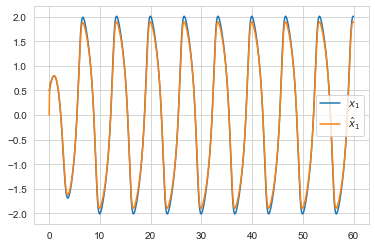

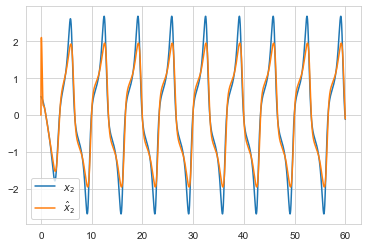

In [6]:
# Plot ground truth and state estimation
import matplotlib.pyplot as plt
for i in range(simulation.shape[1]):
        plt.plot(tq, simulation[:, i, 0], label=rf'$x_{i+1}$')
        plt.plot(tq, estimation[:, i].detach().numpy(),
                 label=rf'$\hat{{x}}_{i+1}$')
        plt.legend()
        plt.show()